In [ ]:
frames[0]

In [ ]:
import json
dataset_name = 'gridworld_small'
object_names = ['_'.join(a.split('_')[:-1]) for a in sorted(gridworld.get_causals())]
action_types = ['turn', 'change_state', 'move_to']
flattened_causals = list(gridworld.causal_vector_to_debug_dict(causals[0]).keys())
causal_keys = list(gridworld.get_causals().keys())
are_interventions_stochastic = True
metadata = {
    'object_names': object_names,
    'action_types': action_types,
    'causal_keys': causal_keys,
    'flattened_causals': flattened_causals,
    'are_interventions_stochastic': are_interventions_stochastic,
}

# Save the metadata
for split in ('train', 'val', 'test_indep'):
    with open(f'data/{dataset_name}/{split}_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=4)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def format_causal_dict(causal_dict):
    formatted_text = ""
    for key, value in causal_dict.items():
        formatted_text += f"{key}: {value}\n"
        if "position_y" in key:  # Add a line break after each entity's details
            formatted_text += "\n"
    return formatted_text

def visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions):
    for i in range(len(frames)):
        debug_causals = Gridworld.causal_vector_to_debug_dict(causal_keys, causals[i])
        formatted_causals = format_causal_dict(debug_causals)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax1 = plt.subplot(1, 2, 1)  # Frame subplot
        ax1.imshow(frames[i])
        ax1.set_title(f"Frame {i+1}")
        ax1.axis('off')

        ax2 = plt.subplot(1, 2, 2)  # Textual information subplot
        ax2.axis('off')
        text_info = (
            f"Step {i+1}:\n\n"
            f"Causals (Formatted):\n{formatted_causals}\n"
            f"Action: {actions[i]}\n"
            f"Action Description: {action_descriptions[i]}\n"
            f"Interventions: {interventions[i]}"
        )
        ax2.text(0, 1, text_info, ha='left', va='top', fontsize=8, wrap=True)

        plt.tight_layout()
        plt.show()

# Usage
# visualize_episode(gridworld, frames, causals, actions, action_descriptions, interventions)

In [ ]:
import multiprocessing
import random
from functools import partial
import os

def run_simulation(seed, split, dataset_name='gridworld', grid_x=16, grid_y=16, sprite_size=32, fixed_light_positions=[]):

    random.seed(seed)
    np.random.seed(seed)
    
    car_colors = [
        (255, 0, 0), # Red
        (0, 0, 255), # Blue
        # (0, 255, 255), # Cyan
        (192, 192, 192), # Silver
        # (255, 165, 0), # Orange
    ]
    light_colors = [
        # (0, 0, 255), # Blue
        (0, 255, 255), # Cyan
        (192, 192, 192), # Silver
        # (255, 165, 0), # Orange
        (100, 100, 0), # Dark Olive
    ]
    boulder_colors = [
        (255, 0, 0), # Red
        # (0, 0, 255), # Blue
        (0, 255, 255), # Cyan
        # (192, 192, 192), # Silver
        (255, 165, 0), # Orange
    ]

    # Preload sprites for each entity type with their specific color subsets
    colors_dict = {
        'cars': car_colors,
        'lights': light_colors,
        'boulders': boulder_colors
    }
    orientations = ['up', 'down', 'left', 'right']
    GridEntity.preload_sprites(colors_dict, orientations, sprite_path='sprites/', sprite_size=sprite_size)

    # Create an instance of Gridworld
    gridworld = Gridworld(grid_x, grid_y, sprite_size=sprite_size)

    # Initialize the gridworld with vehicles, traffic lights, and boulders
    gridworld.randomly_initialize(car_colors, light_colors, boulder_colors, num_cars=3, num_lights=3, num_boulders=3, fixed_light_positions=fixed_light_positions, x_percent=50, y_percent=10, z_percent=20)

    # Run the simulation
    gridworld.step()  # Initial step to set up the environment
    initial_frame = gridworld.render()
    initial_causal_vector = gridworld.get_causal_vector(are_light_positions_fixed=True)

    frames = [initial_frame.copy()]  # List of frames, starting with the initial frame
    causals = [initial_causal_vector]  # List of causals, starting with the initial state
    actions = []  # List of actions
    action_descriptions = []  # List of action descriptions
    interventions = []  # List of interventions

    # Generation loop
    for _ in range(1, 20):  # Start from 1 since we already have the initial state
        action, intervention = gridworld.semi_random_intervention()
        gridworld.step()
        
        # Append action and intervention information
        actions.append(action)
        interventions.append(gridworld.interventions_to_binary_vector(intervention, gridworld.get_causals()))

        # Append causal information
        causals.append(gridworld.get_causal_vector(are_light_positions_fixed=True))
        
        # Append action description
        action_description = gridworld.describe_action(gridworld.get_causals(), action)
        action_descriptions.append(action_description)

        # Render and save the frame
        frame = gridworld.render()
        # frame_name = f"{seed}_{gridworld.step_count}.png"
        # frame.save(f"frames/{frame_name}")
        frames.append(frame.copy())
    
    # Create a directory if it doesn't exist
    if not os.path.exists(f'data/{dataset_name}/{split}'):
        os.makedirs(f'data/{dataset_name}/{split}', exist_ok=True)
    
    np.savez_compressed(f'data/{dataset_name}/{split}/gridworld_episode_{seed}.npz', 
                frames=np.array(frames),
                causals=np.array(causals),
                actions=np.array(actions),
                interventions=np.array(interventions))
    
    # frames[0].save(f'gifs/gridworld_random_{seed}.gif', save_all=True, append_images=frames[1:], duration=300, loop=0, disposal=2)


from multiprocessing import Pool
from tqdm.notebook import tqdm

def run_batch(batch_seeds, split, dataset_name='gridworld', grid_x=16, grid_y=16, sprite_size=32, fixed_light_positions=[]):
    for seed in batch_seeds:
        run_simulation(seed, split, dataset_name, grid_x, grid_y, sprite_size, fixed_light_positions)

def gen_data(seeds, batch_size, split, dataset_name='gridworld', grid_x=16, grid_y=16, sprite_size=32, fixed_light_positions=[]):
    run_batch_split = partial(run_batch, split=split, dataset_name=dataset_name, grid_x=grid_x, grid_y=grid_y, sprite_size=sprite_size, fixed_light_positions=fixed_light_positions)
    batches = [seeds[i:i + batch_size] for i in range(0, len(seeds), batch_size)]
    
    with Pool() as pool:
        # Wrap pool.map with tqdm for progress tracking
        list(tqdm(pool.imap_unordered(run_batch_split, batches), total=len(batches)))

def main():
    # # Train split
    grid_x, grid_y = 8, 8
    sprite_size = 32
    fixed_light_positions = [(0, 0, 'down'), (3, grid_y - 1, 'up'), (grid_x - 3, 0, 'down')]
    train_seeds = 1000
    batch_size = 50  # Adjust based on your system's capability
    seeds = range(train_seeds)

    gen_data(seeds, batch_size, 'train', dataset_name='gridworld_small', grid_x=grid_x, grid_y=grid_y, sprite_size=sprite_size, fixed_light_positions=fixed_light_positions)
        
    # # Validation split
    val_seeds = 100
    batch_size = 50  # Adjust based on your system's capability
    seeds = range(train_seeds, train_seeds + val_seeds)
    
    gen_data(seeds, batch_size, 'val', dataset_name='gridworld_small', grid_x=grid_x, grid_y=grid_y, sprite_size=sprite_size, fixed_light_positions=fixed_light_positions)
    
    # Test split
    test_seeds = 100
    batch_size = 50  # Adjust based on your system's capability
    seeds = range(train_seeds + val_seeds, train_seeds + val_seeds + test_seeds)
    
    gen_data(seeds, batch_size, 'test', dataset_name='gridworld_small', grid_x=grid_x, grid_y=grid_y, sprite_size=sprite_size, fixed_light_positions=fixed_light_positions)
main()

In [ ]:
original_causals = gridworld.get_causals()
causal_vector = causals[-1]
converted_causals = gridworld.causal_vector_to_causals(causal_vector)

all_keys_match = sorted(original_causals.keys()) == sorted(converted_causals.keys())
all_values_match = all([original_causals[key] == converted_causals[key] for key in original_causals])

all_keys_match and all_values_match

In [ ]:
from matplotlib import pyplot as plt
# Convert frame to numpy array
frame_np = np.array(frames[0])
print(frame_np.shape)
# Turn the transparent background into white
frame_np[frame_np[:, :, 3] == 0] = 0
plt.imshow(frame_np)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Define nodes for the graph
nodes = [
    'vehicle1_pos', 'vehicle1_or',
    'vehicle2_pos', 'vehicle2_or',
    'light1_state', 'light1_or',
    'light2_state', 'light2_or',
    'boulder1_pos', 'boulder2_pos'
]

# Extend nodes to include both t and t+1
extended_nodes = [f"{node}_t" for node in nodes] + [f"{node}_t+1" for node in nodes]

# Initialize the adjacency matrix for the extended nodes
extended_adj_matrix = np.zeros((len(extended_nodes), len(extended_nodes)))

# Define the indices for the extended nodes
extended_node_indices = {node: i for i, node in enumerate(extended_nodes)}

for node in nodes:
    # Adding temporal edges
    extended_adj_matrix[extended_node_indices[f'{node}_t'], extended_node_indices[f'{node}_t+1']] = 1

# Adding causal edges based on relationships
for vehicle in ['vehicle1', 'vehicle2']:
    for other_vehicle in ['vehicle1', 'vehicle2']:
        if vehicle != other_vehicle:
            # Vehicle's next pos potentially influenced by the other vehicle's pos and or
            extended_adj_matrix[extended_node_indices[f'{other_vehicle}_pos_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5
            extended_adj_matrix[extended_node_indices[f'{other_vehicle}_or_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5
    for light in ['light1', 'light2']:
        # Vehicle's next pos potentially influenced by traffic lights' state and orientation
        extended_adj_matrix[extended_node_indices[f'{light}_state_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5
        extended_adj_matrix[extended_node_indices[f'{light}_or_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5
        # extended_adj_matrix[extended_node_indices[f'{light}_pos_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5
    for boulder in ['boulder1', 'boulder2']:
        # Vehicle's next pos potentially influenced by boulders' pos
        extended_adj_matrix[extended_node_indices[f'{boulder}_pos_t'], extended_node_indices[f'{vehicle}_pos_t+1']] = 0.5

# Create a directed graph from the extended adjacency matrix
extended_G = nx.DiGraph(extended_adj_matrix)

# Function to draw the graph with a specified layout
def draw_graph(G, pos, title, figsize=(12, 18)):
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=7000)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=25, 
                           edgelist=[(u, v) for u, v, d in G.edges(data=True) if d['weight'] == 1])
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=25, style='dashed',
                           edgelist=[(u, v) for u, v, d in G.edges(data=True) if d['weight'] == 0.5])
    nx.draw_networkx_labels(G, pos, labels={i: node for i, node in enumerate(extended_nodes)}, font_size=10)
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Define poss for horizontal and vertical layouts
num_nodes = len(extended_nodes) // 2
horizontal_pos = {**{i: np.array([0, -i]) for i in range(num_nodes)},
                  **{i + num_nodes: np.array([2, -i]) for i in range(num_nodes)}}
vertical_pos = {**{i: np.array([-i, 0]) for i in range(num_nodes)},
                **{i + num_nodes: np.array([-i, -2]) for i in range(num_nodes)}}

# Draw the graph with horizontal layout
draw_graph(extended_G, horizontal_pos, "Causal Graph for 2 Vehicles, 2 Traffic Lights, and 2 Boulders")

In [ ]:
import os
# Import "../"
import sys
import torch
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from experiments.datasets import GridworldDataset
data_folder = 'data/gridworld'
split = 'train'
gridworld_dataset = GridworldDataset(data_folder, split, single_image=True, subsample_percentage=0.05)
dataloader = torch.utils.data.DataLoader(gridworld_dataset, batch_size=50, shuffle=True)

In [ ]:
a = next(iter(dataloader))
a[0][0].shape

In [ ]:
causals[0]

In [ ]:
Gridworld.causal_vector_to_debug_dict(causal_keys, causals[0])

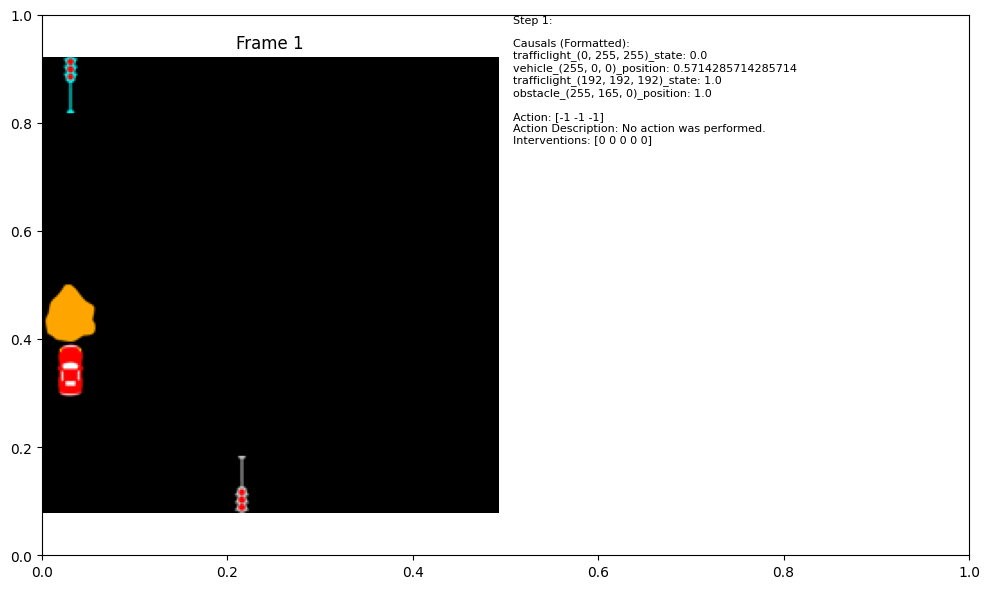

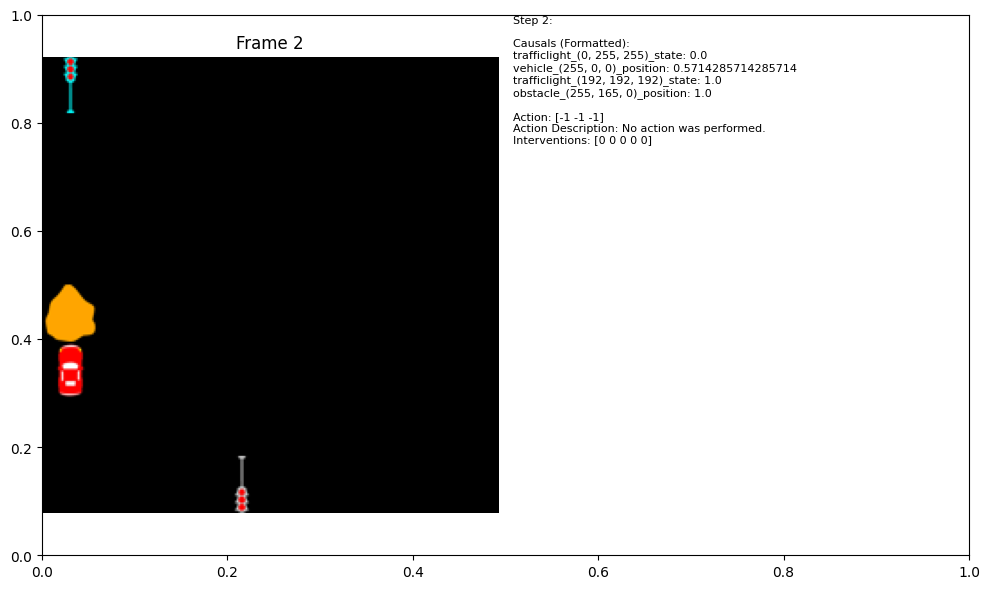

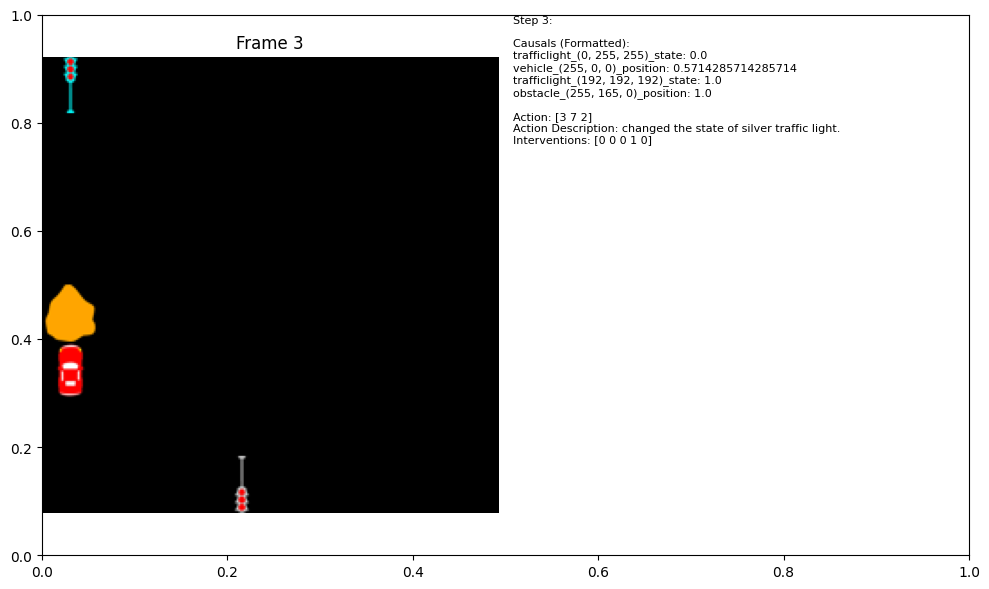

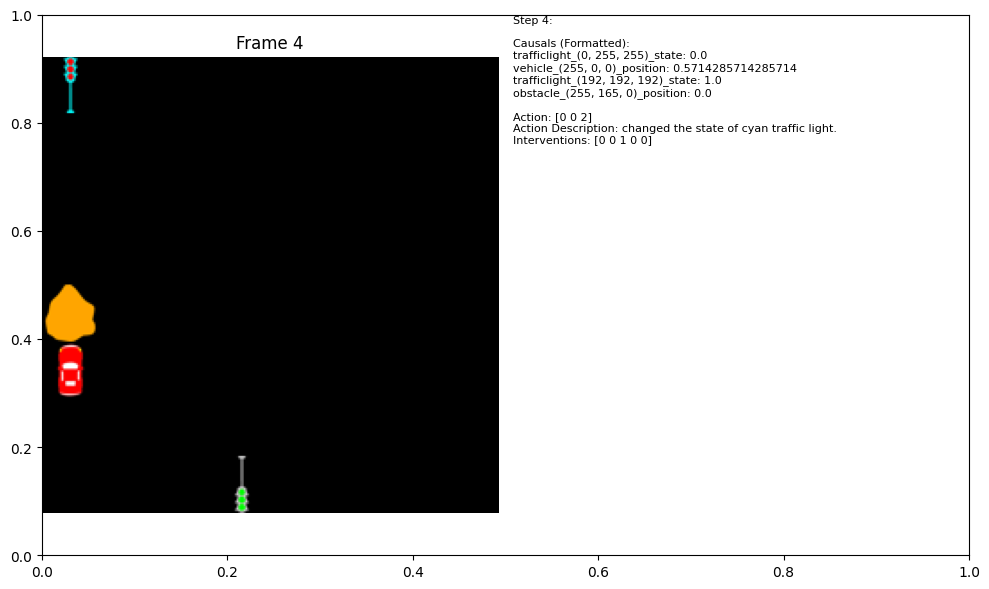

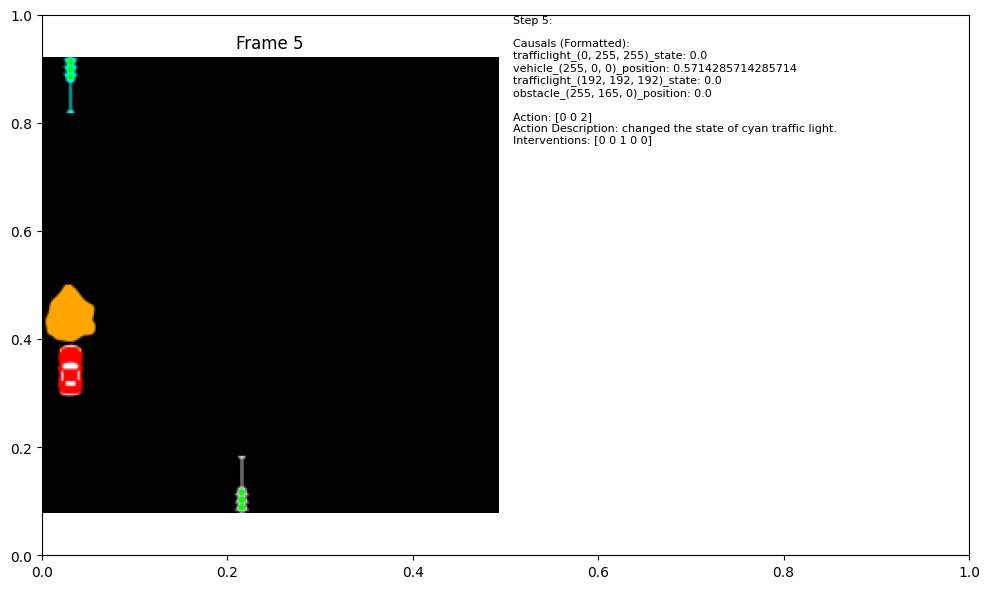

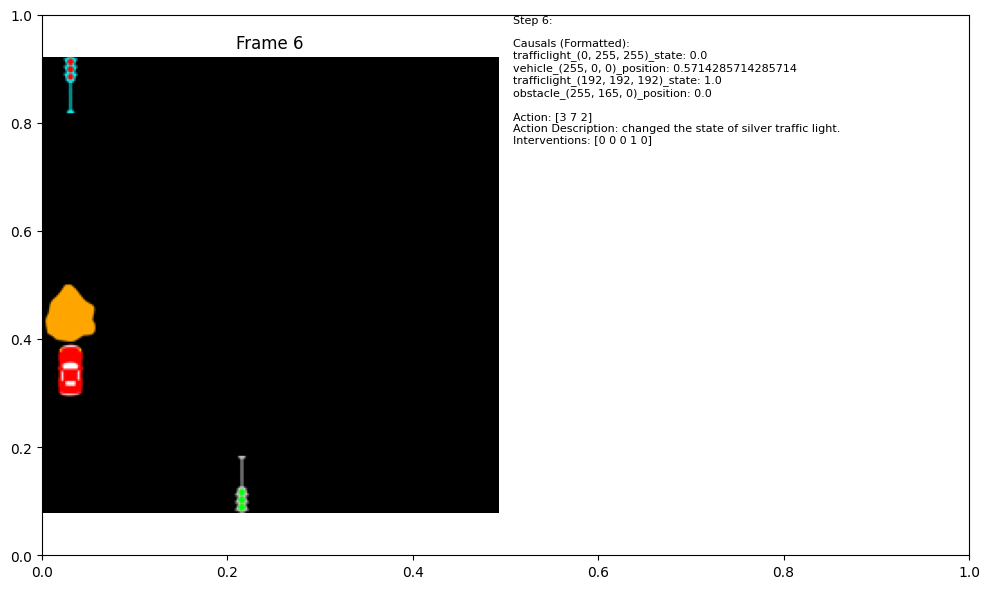

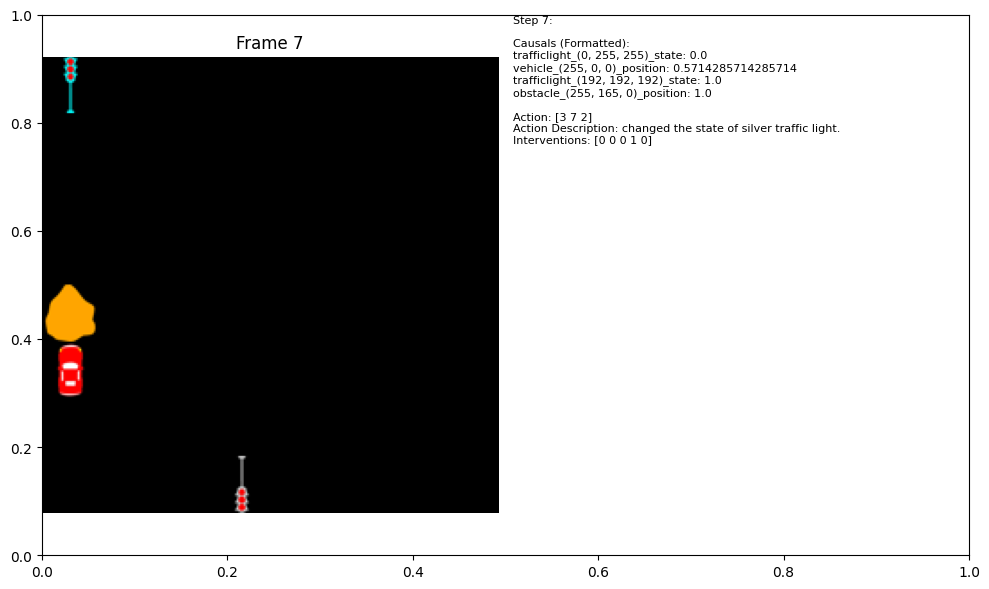

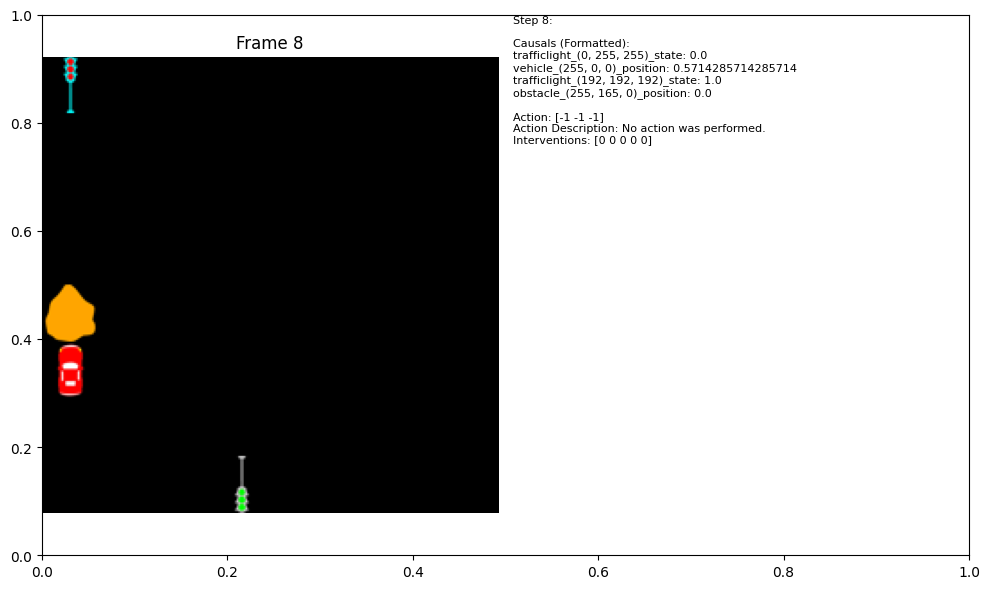

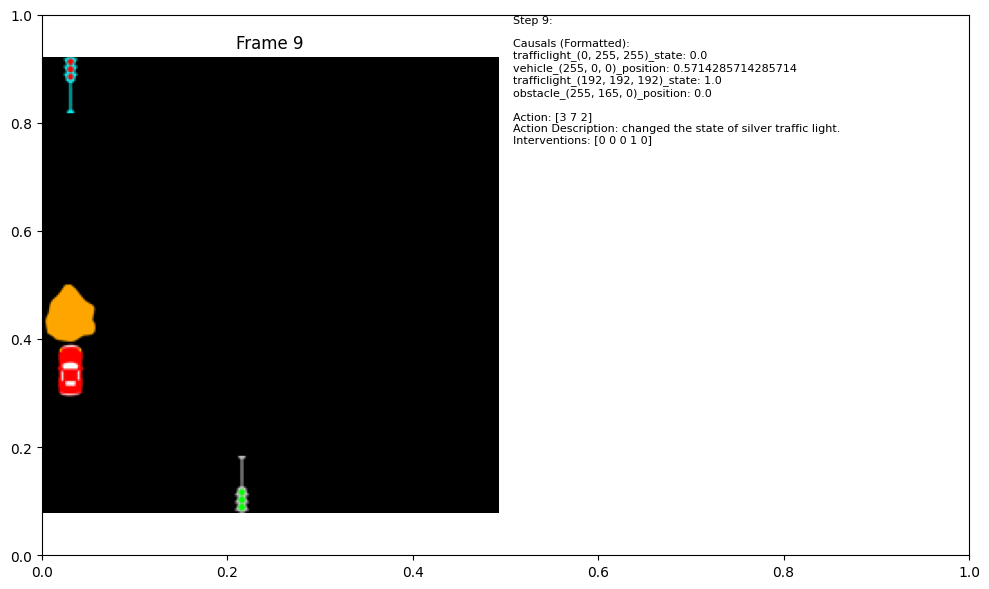

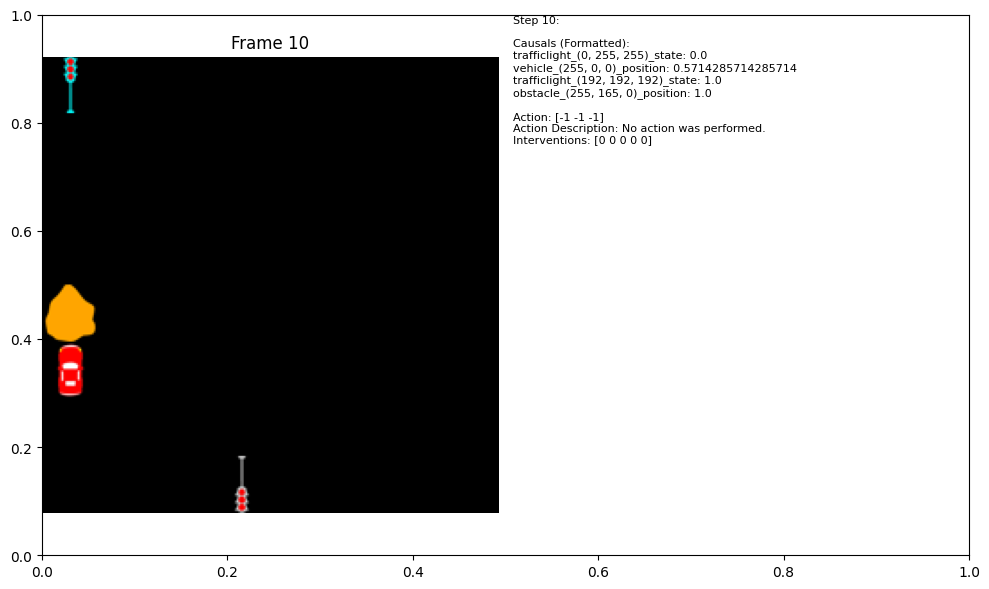

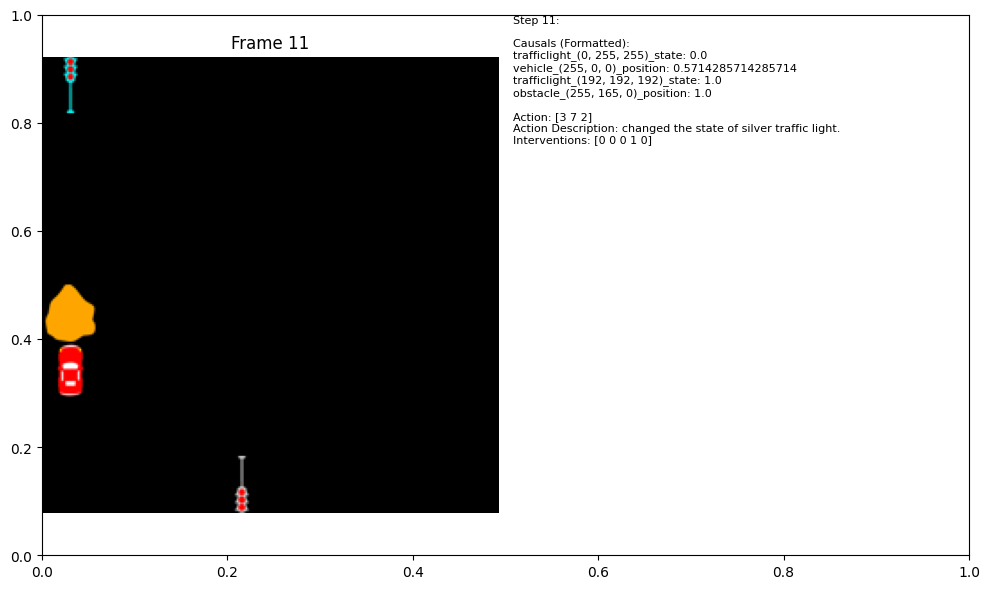

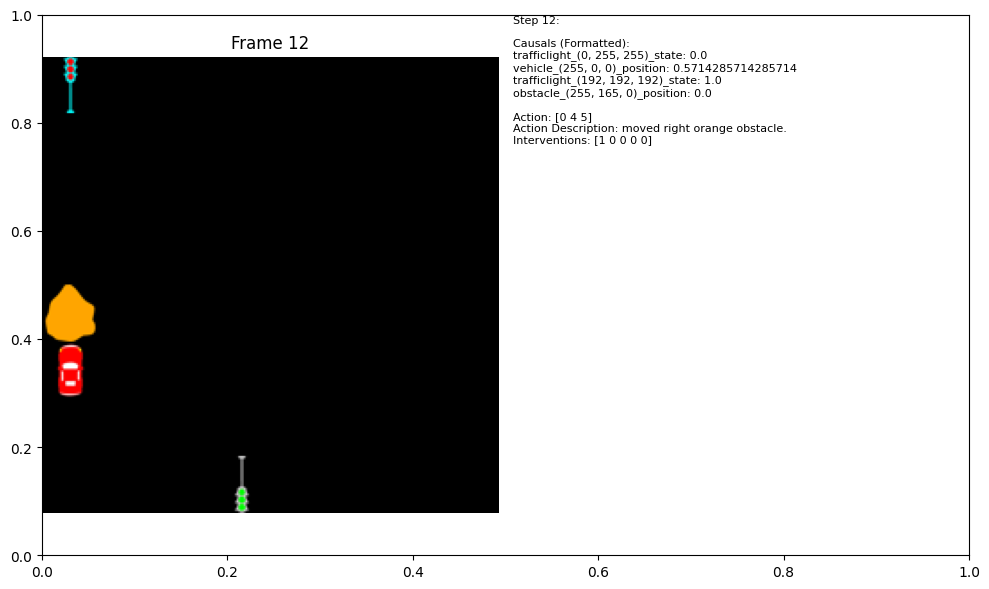

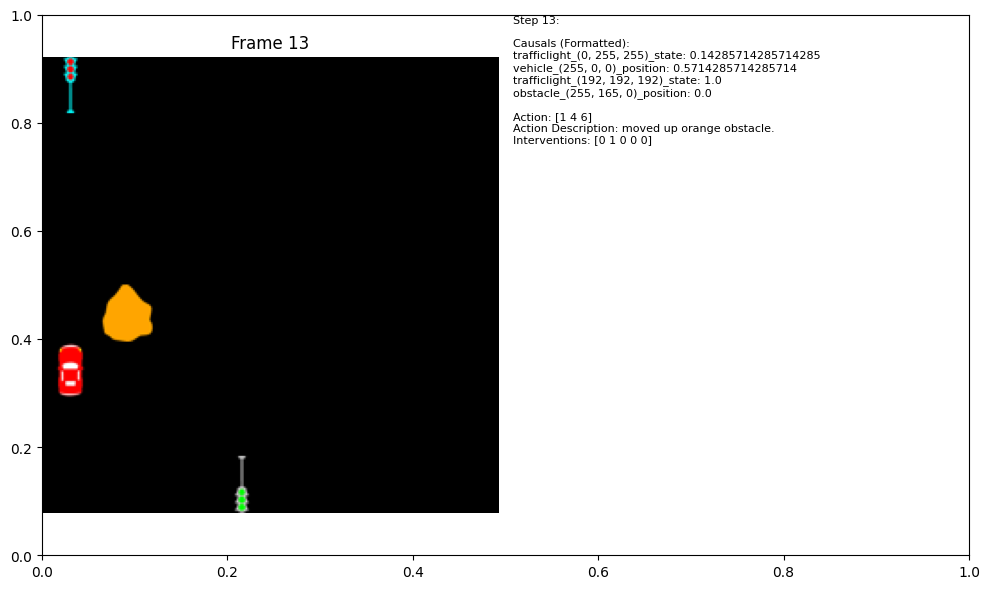

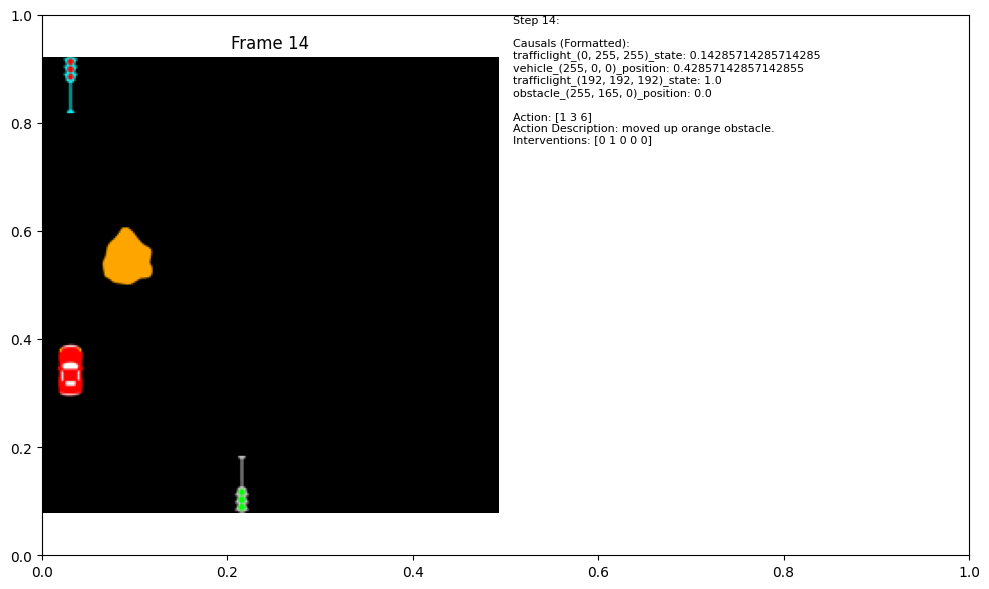

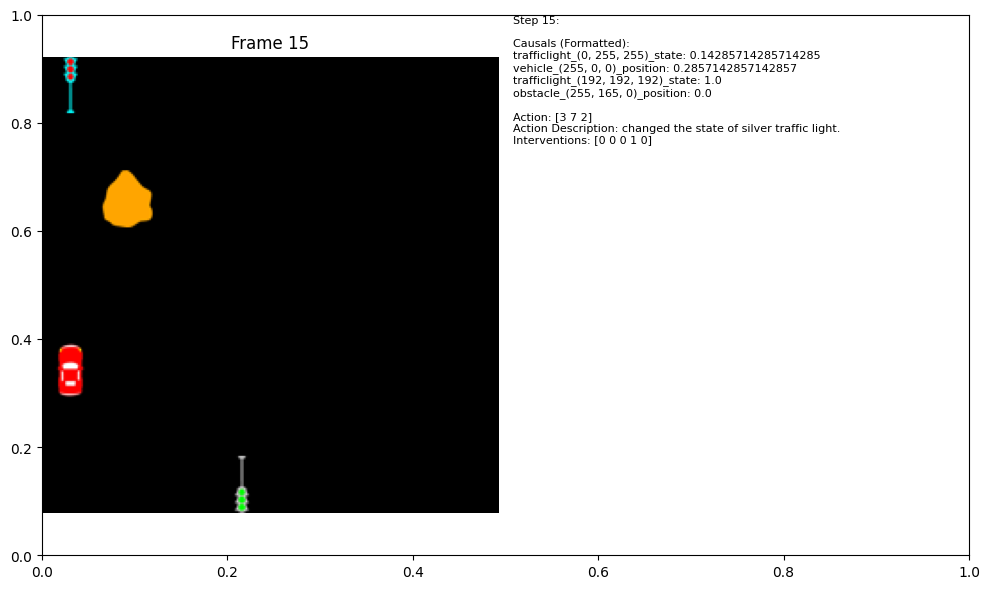

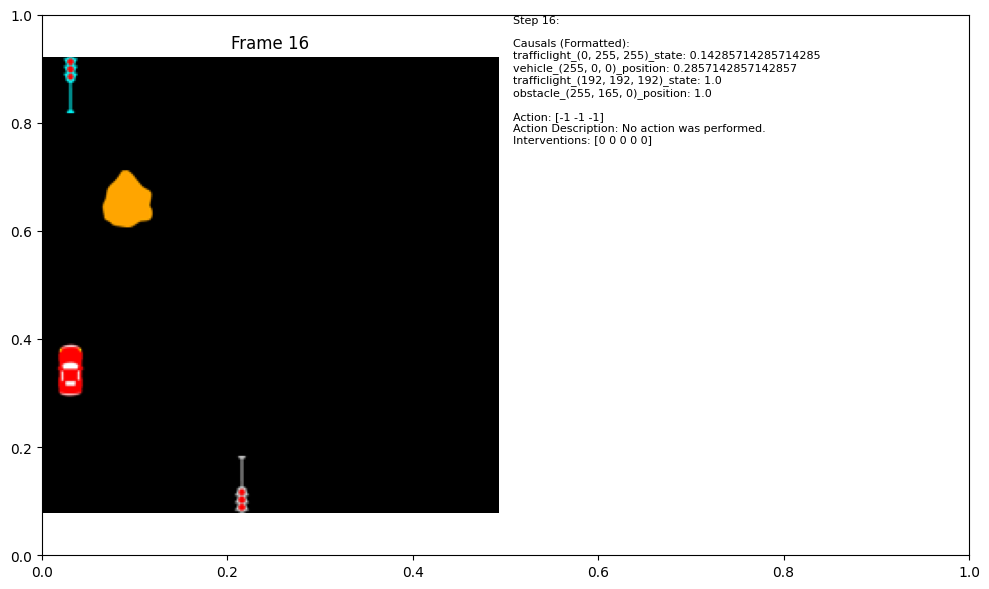

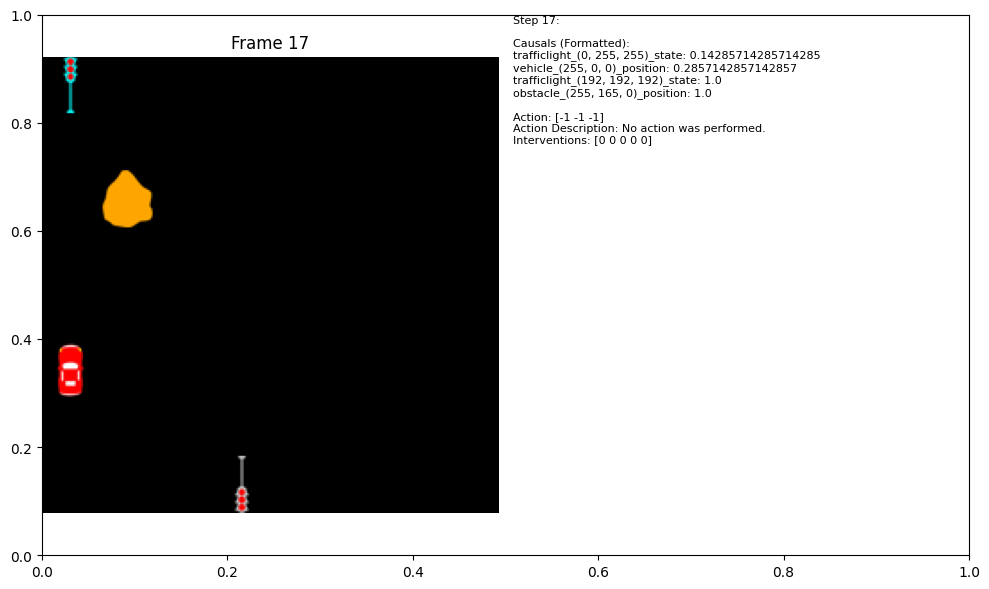

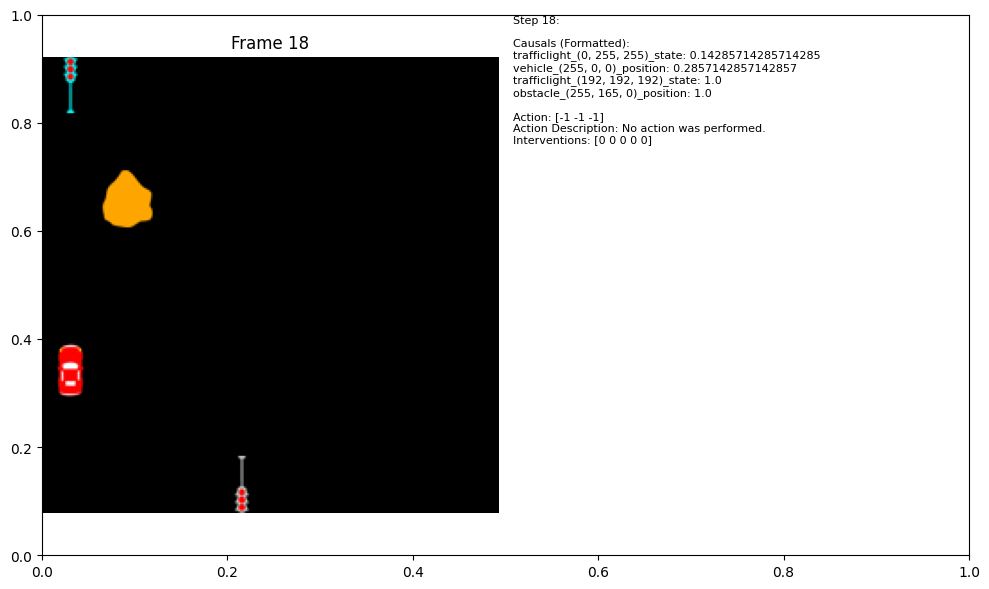

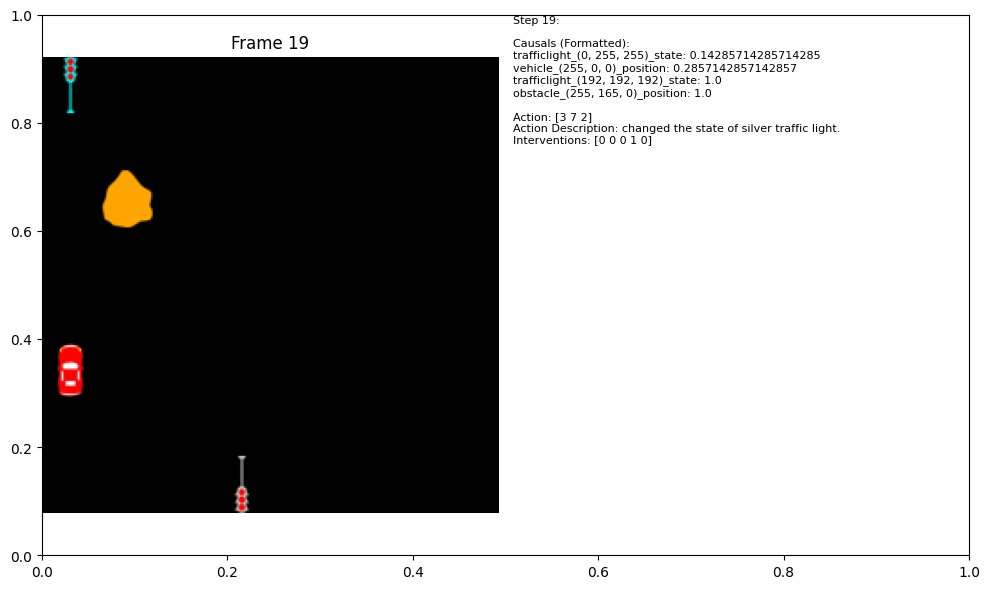

IndexError: index 19 is out of bounds for axis 0 with size 19

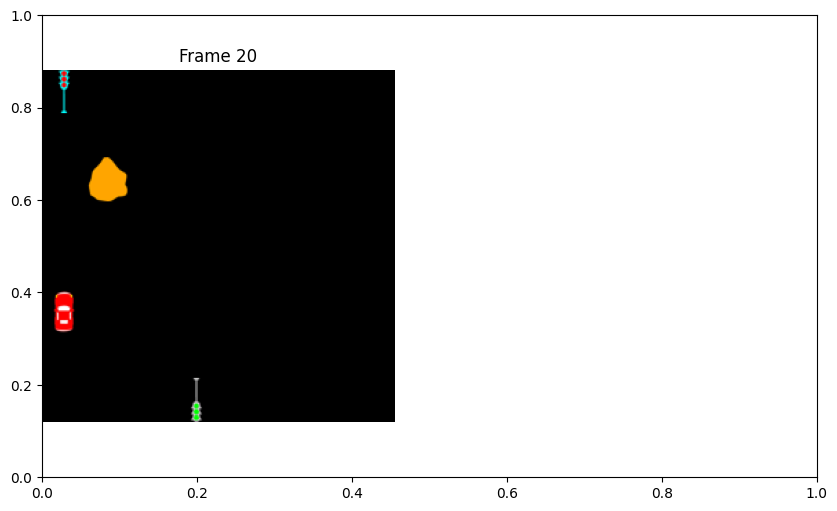

In [14]:
import numpy as np
import json
from gridworld import Gridworld
from PIL import Image
import matplotlib.pyplot as plt

def format_causal_dict(causal_dict):
    formatted_text = ""
    for key, value in causal_dict.items():
        formatted_text += f"{key}: {value}\n"
        if "position_y" in key:  # Add a line break after each entity's details
            formatted_text += "\n"
    return formatted_text

def visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions):
    for i in range(len(frames)):
        # debug_causals = Gridworld.causal_vector_to_debug_dict(causal_keys, causals[i])
        debug_causals = dict(zip(causal_keys, causals[i]))
        formatted_causals = format_causal_dict(debug_causals)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax1 = plt.subplot(1, 2, 1)  # Frame subplot
        ax1.imshow(frames[i])
        ax1.set_title(f"Frame {i+1}")
        ax1.axis('off')

        ax2 = plt.subplot(1, 2, 2)  # Textual information subplot
        ax2.axis('off')
        text_info = (
            f"Step {i+1}:\n\n"
            f"Causals (Formatted):\n{formatted_causals}\n"
            f"Action: {actions[i]}\n"
            f"Action Description: {action_descriptions[i]}\n"
            f"Interventions: {interventions[i]}"
        )
        ax2.text(0, 1, text_info, ha='left', va='top', fontsize=8, wrap=True)

        plt.tight_layout()
        plt.show()

a = np.load('/home/john/PhD/BISCUIT/data_generation/data/gridworld_simplified_5c/check/gridworld_episode_15.npz')
causal_keys = json.load(open('/home/john/PhD/BISCUIT/data_generation/data/gridworld_simplified_5c/check_metadata.json'))['causal_keys']
frames, causals, actions, interventions, action_descriptions = a['frames'], a['causals'], a['actions'], a['interventions'], a['action_descriptions']
visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions)

In [ ]:
from datasets import GridworldDataset, iTHORDataset
import torch

val_seq_dataset_gridworld = GridworldDataset(
	data_folder=args.data_dir, split='val', single_image=False, triplet=False, seq_len=args.seq_len, cluster=args.cluster, return_text=args.text, subsample_percentage=1.0, **dataset_args)